In [1]:
import sys, platform, subprocess, torch

print("Python:", sys.version)
print("Platform:", platform.platform())
print("CUDA available:", torch.cuda.is_available())
print("Torch:", torch.__version__)


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
CUDA available: False
Torch: 2.8.0+cu126


In [2]:
!pip -q install sentence-transformers umap-learn scikit-learn spacy textstat tqdm
!python -m spacy download en_core_web_sm -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 118.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import pathlib, os

PROJECT = "ctrl_style"
BASE = pathlib.Path("/content") / PROJECT
for p in ["data/raw","data/processed","notebooks","src","results/figures","results/tables","paper"]:
    (BASE/p).mkdir(parents=True, exist_ok=True)

print("PROJECT DIR:", BASE)
for root, dirs, files in os.walk(BASE):
    level = root.replace(str(BASE), "").count(os.sep)
    indent = "  " * level
    print(f"{indent}{pathlib.Path(root).name}/")
    for f in files:
        print(f"{indent}  {f}")


PROJECT DIR: /content/ctrl_style
ctrl_style/
  data/
    raw/
    processed/
  paper/
  src/
  notebooks/
  results/
    figures/
    tables/


In [4]:
import numpy as np, random, matplotlib as mpl, matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

mpl.rcParams.update({
    "figure.dpi": 140,
    "figure.figsize": (8, 4.5),
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "font.size": 11
})
print("Seeds fixed and plotting style set.")


Seeds fixed and plotting style set.


In [5]:
import pandas as pd, sklearn, umap, textstat, spacy, sentence_transformers

print("pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)
print("umap-learn:", umap.__version__)
print("spaCy:", spacy.__version__)
print("textstat:", textstat.__version__)
print("sentence-transformers:", sentence_transformers.__version__)


pandas: 2.2.2
scikit-learn: 1.6.1
umap-learn: 0.5.9.post2
spaCy: 3.8.8
textstat: (0, 7, 11)
sentence-transformers: 5.1.2


### **STEP 2**

In [6]:
import time, requests, pandas as pd
from pathlib import Path

RAW_CSV = BASE/"data/raw/gutenberg_raw.csv"

sources = [
    # Jane Austen
    ("Jane Austen", "Pride and Prejudice", "https://www.gutenberg.org/files/1342/1342-0.txt"),
    ("Jane Austen", "Sense and Sensibility", "https://www.gutenberg.org/files/161/161-0.txt"),
    ("Jane Austen", "Emma", "https://www.gutenberg.org/files/158/158-0.txt"),
    # Mark Twain
    ("Mark Twain", "The Adventures of Tom Sawyer", "https://www.gutenberg.org/files/74/74-0.txt"),
    ("Mark Twain", "Adventures of Huckleberry Finn", "https://www.gutenberg.org/files/76/76-0.txt"),
    ("Mark Twain", "A Connecticut Yankee in King Arthur's Court", "https://www.gutenberg.org/files/86/86-0.txt"),
]

def fetch(url, tries=3, pause=2):
    last_exc = None
    for k in range(tries):
        try:
            r = requests.get(url, timeout=60)
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_exc = e
            time.sleep(pause*(k+1))
    raise last_exc

rows = []
for author, title, url in sources:
    txt = fetch(url)
    rows.append({"author": author, "title": title, "url": url, "raw_text": txt})

df_raw = pd.DataFrame(rows)
df_raw.to_csv(RAW_CSV, index=False)
print("Saved:", RAW_CSV, "| rows:", len(df_raw))
df_raw.head(6)



Saved: /content/ctrl_style/data/raw/gutenberg_raw.csv | rows: 6


,author,title,url,raw_text
0,Jane Austen,Pride and Prejudice,https://www.gutenberg.org/files/1342/1342-0.txt,*** START OF THE PROJECT GUTENBERG EBOOK 1342 ...
1,Jane Austen,Sense and Sensibility,https://www.gutenberg.org/files/161/161-0.txt,﻿The Project Gutenberg eBook of Sense and Sens...
2,Jane Austen,Emma,https://www.gutenberg.org/files/158/158-0.txt,*** START OF THE PROJECT GUTENBERG EBOOK 158 *...
3,Mark Twain,The Adventures of Tom Sawyer,https://www.gutenberg.org/files/74/74-0.txt,﻿*** START OF THE PROJECT GUTENBERG EBOOK THE ...
4,Mark Twain,Adventures of Huckleberry Finn,https://www.gutenberg.org/files/76/76-0.txt,*** START OF THE PROJECT GUTENBERG EBOOK 76 **...
5,Mark Twain,A Connecticut Yankee in King Arthur's Court,https://www.gutenberg.org/files/86/86-0.txt,*** START OF THE PROJECT GUTENBERG EBOOK 86 **...


In [7]:
import re, pandas as pd

def strip_gutenberg_boilerplate(t: str) -> str:
    start_pat = r"\*\*\* START OF (THIS|THE) PROJECT GUTENBERG EBOOK .* \*\*\*"
    end_pat   = r"\*\*\* END OF (THIS|THE) PROJECT GUTENBERG EBOOK .* \*\*\*"
    start = re.search(start_pat, t, flags=re.IGNORECASE)
    end   = re.search(end_pat, t, flags=re.IGNORECASE)
    if start and end and start.end() < end.start():
        t = t[start.end():end.start()]
    # унификация переводов строк и пробелов
    t = t.replace("\r", "")
    t = re.sub(r"\n{3,}", "\n\n", t)
    t = re.sub(r"[ \t]{2,}", " ", t)
    return t.strip()

df_clean = df_raw.copy()
df_clean["clean_text"] = df_clean["raw_text"].map(strip_gutenberg_boilerplate)
CLEAN_CSV = BASE/"data/processed/corpus_clean.csv"
df_clean[["author","title","clean_text"]].to_csv(CLEAN_CSV, index=False)
print("Saved:", CLEAN_CSV, "| rows:", len(df_clean))
df_clean[["author","title"]].head()


Saved: /content/ctrl_style/data/processed/corpus_clean.csv | rows: 6


,author,title
0,Jane Austen,Pride and Prejudice
1,Jane Austen,Sense and Sensibility
2,Jane Austen,Emma
3,Mark Twain,The Adventures of Tom Sawyer
4,Mark Twain,Adventures of Huckleberry Finn


In [8]:
import spacy, math, re
from tqdm import tqdm

nlp = spacy.load("en_core_web_sm", disable=["ner","tagger","lemmatizer"])
if "sentencizer" not in nlp.pipe_names:
    nlp.add_pipe("sentencizer")

TARGET_MIN, TARGET_MAX = 150, 300

def chunk_by_words_keep_sentences(text, lo=TARGET_MIN, hi=TARGET_MAX):
    doc = nlp(text)
    chunks, cur, cur_len = [], [], 0
    for sent in doc.sents:
        w = len([t for t in sent if not t.is_space])
        # если добавление предложения не превышает верхний порог — добавляем
        if cur_len + w <= hi:
            cur.append(sent.text)
            cur_len += w
        else:
            # если текущий блок уже достаточно длинный — фиксируем
            if cur_len >= lo:
                chunks.append(" ".join(cur).strip())
                cur, cur_len = [sent.text], w
            else:
                # иначе “переполняем”, чтобы не плодить слишком короткие
                cur.append(sent.text)
                cur_len += w
                if cur_len >= lo:
                    chunks.append(" ".join(cur).strip())
                    cur, cur_len = [], 0
    if cur_len >= lo:
        chunks.append(" ".join(cur).strip())
    return chunks

records = []
for i, row in tqdm(df_clean.iterrows(), total=len(df_clean)):
    parts = chunk_by_words_keep_sentences(row["clean_text"])
    for j, txt in enumerate(parts):
        n_words = len(re.findall(r"\b\w+\b", txt))
        records.append({
            "doc_id": f"{row['author']}::{row['title']}",
            "author": row["author"],
            "title": row["title"],
            "part_id": j,
            "n_words": n_words,
            "text": txt
        })

import pandas as pd
df_passages = pd.DataFrame(records)
# строгий фильтр по длине
df_passages = df_passages[df_passages["n_words"].between(TARGET_MIN, TARGET_MAX)].reset_index(drop=True)

PASSAGES_CSV = BASE/"data/processed/passages.csv"
df_passages.to_csv(PASSAGES_CSV, index=False)
print("Saved:", PASSAGES_CSV, "| rows:", len(df_passages))
df_passages.groupby("author").size()


100%|██████████| 6/6 [02:57<00:00, 29.57s/it]


Saved: /content/ctrl_style/data/processed/passages.csv | rows: 3049


,0
author,
Jane Austen,1732
Mark Twain,1317


In [9]:
from sklearn.model_selection import train_test_split

df = df_passages.copy()
# балансируем по авторам (одинаковое число пассажей от каждого автора)
min_per_author = df.groupby("author").size().min()
df_bal = pd.concat([g.sample(min_per_author, random_state=SEED) for _, g in df.groupby("author")], ignore_index=True)

train_df, temp_df = train_test_split(df_bal, test_size=0.30, random_state=SEED, stratify=df_bal["author"])
val_df,   test_df = train_test_split(temp_df, test_size=0.50, random_state=SEED, stratify=temp_df["author"])

for name, split in [("train",train_df),("val",val_df),("test",test_df)]:
    out = BASE/f"data/processed/{name}.csv"
    split.to_csv(out, index=False)
    print(f"{name:5s}", "→", out, "| size:", len(split), "| by author:", split["author"].value_counts().to_dict())


train → /content/ctrl_style/data/processed/train.csv | size: 1843 | by author: {'Mark Twain': 922, 'Jane Austen': 921}
val   → /content/ctrl_style/data/processed/val.csv | size: 395 | by author: {'Jane Austen': 198, 'Mark Twain': 197}
test  → /content/ctrl_style/data/processed/test.csv | size: 396 | by author: {'Mark Twain': 198, 'Jane Austen': 198}


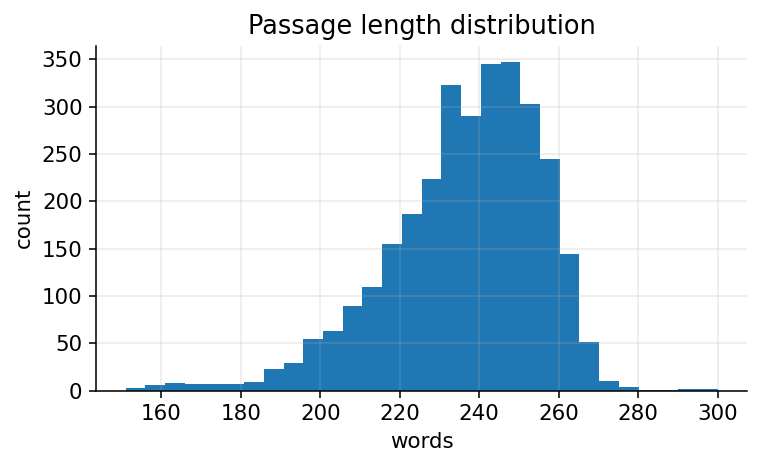

train: n=1843 | per author: {'Mark Twain': np.int64(922), 'Jane Austen': np.int64(921)}
val: n=395 | per author: {'Jane Austen': np.int64(198), 'Mark Twain': np.int64(197)}
test: n=396 | per author: {'Mark Twain': np.int64(198), 'Jane Austen': np.int64(198)}


In [10]:
import matplotlib.pyplot as plt
import pandas as pd

dfp = pd.read_csv(PASSAGES_CSV)
fig, ax = plt.subplots(figsize=(6,3.2))
dfp["n_words"].plot.hist(bins=30, ax=ax)
ax.set_title("Passage length distribution")
ax.set_xlabel("words"); ax.set_ylabel("count")
plt.show()

for name in ["train","val","test"]:
    tmp = pd.read_csv(BASE/f"data/processed/{name}.csv")
    print(f"{name}: n={len(tmp)} | per author:", dict(tmp["author"].value_counts()))


In [11]:
import pandas as pd

summary = (
    df_passages
      .groupby(["author","title"])
      .agg(passages=("text","count"), mean_words=("n_words","mean"))
      .reset_index()
      .sort_values(["author","title"])
)

SUMMARY_CSV = BASE/"results/tables/corpus_summary.csv"
summary.to_csv(SUMMARY_CSV, index=False)
print("Saved:", SUMMARY_CSV)
summary.head(10)


Saved: /content/ctrl_style/results/tables/corpus_summary.csv


,author,title,passages,mean_words
0,Jane Austen,Emma,682,236.661290
1,Jane Austen,Pride and Prejudice,543,236.944751
2,Jane Austen,Sense and Sensibility,507,237.355030
3,Mark Twain,A Connecticut Yankee in King Arthur's Court,504,237.871032
4,Mark Twain,Adventures of Huckleberry Finn,497,234.607646
5,Mark Twain,The Adventures of Tom Sawyer,316,235.268987


# STEP **3**

In [12]:
from pathlib import Path
import pandas as pd, numpy as np, json, os

# папки с артефактами
MODELS_DIR = BASE/"results/models"
FIG_DIR    = BASE/"results/figures"
TABLE_DIR  = BASE/"results/tables"
for p in [MODELS_DIR, FIG_DIR, TABLE_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# загружаем сплиты (на случай если не в памяти)
TRAIN_CSV = BASE/"data/processed/train.csv"
VAL_CSV   = BASE/"data/processed/val.csv"
TEST_CSV  = BASE/"data/processed/test.csv"

train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
test_df  = pd.read_csv(TEST_CSV)

label_map = {a:i for i,a in enumerate(sorted(train_df["author"].unique()))}
inv_map   = {v:k for k,v in label_map.items()}
y_train = train_df["author"].map(label_map).to_numpy()
y_val   = val_df["author"].map(label_map).to_numpy()
y_test  = test_df["author"].map(label_map).to_numpy()

np.save(MODELS_DIR/"y_train.npy", y_train)
np.save(MODELS_DIR/"y_val.npy",   y_val)
np.save(MODELS_DIR/"y_test.npy",  y_test)

print("Splits:", len(train_df), len(val_df), len(test_df))
print("Labels:", inv_map)


Splits: 1843 395 396
Labels: {0: 'Jane Austen', 1: 'Mark Twain'}


In [13]:
import torch
from sentence_transformers import SentenceTransformer

device = "cuda" if torch.cuda.is_available() else "cpu"

# Быстрый и качественный эмбеддер (чтобы не ждать час).
# Для финального прогона можно поменять на "sentence-transformers/all-mpnet-base-v2".
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

model = SentenceTransformer(MODEL_NAME, device=device)
model.max_seq_length = 256  # пассажи 150–300 слов; этого хватает
BATCH = 128 if device == "cuda" else 16

print("Device:", device, "| Model:", MODEL_NAME, "| Batch:", BATCH)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Device: cpu | Model: sentence-transformers/all-MiniLM-L6-v2 | Batch: 16


In [14]:
import numpy as np

def encode_split(df, split_name, batch_size=BATCH, overwrite=False):
    x_path = MODELS_DIR/f"X_{split_name}.npy"

    # если уже посчитано и не требуем пересчёт — грузим
    if x_path.exists() and not overwrite:
        X = np.load(x_path, allow_pickle=False)
        if len(X) == len(df):
            print(f"[cache] Loaded {split_name} from", x_path)
            return X
        else:
            print(f"[warn] Cache size mismatch for {split_name}, recomputing...")

    # считаем заново и сохраняем
    texts = list(df["text"])
    X = model.encode(
        texts, batch_size=batch_size, show_progress_bar=True,
        convert_to_numpy=True, normalize_embeddings=True
    )

    # сохраняем атомарно
    tmp = str(x_path) + ".tmp.npy"
    np.save(tmp, X)
    os.replace(tmp, x_path)

    print(f"[saved] {split_name} →", x_path, "| shape:", X.shape)
    return X


In [15]:
X_train = encode_split(train_df, "train", batch_size=BATCH)
X_val   = encode_split(val_df,   "val",   batch_size=BATCH)
X_test  = encode_split(test_df,  "test",  batch_size=BATCH)

meta = {"model": MODEL_NAME, "device": device, "normalized": True, "max_seq_length": model.max_seq_length}
with open(MODELS_DIR/"meta.json","w") as f:
    json.dump(meta, f, indent=2)
X_train.shape, X_val.shape, X_test.shape


Batches:   0%|          | 0/116 [00:00<?, ?it/s]

[saved] train → /content/ctrl_style/results/models/X_train.npy | shape: (1843, 384)


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

[saved] val → /content/ctrl_style/results/models/X_val.npy | shape: (395, 384)


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

[saved] test → /content/ctrl_style/results/models/X_test.npy | shape: (396, 384)


((1843, 384), (395, 384), (396, 384))

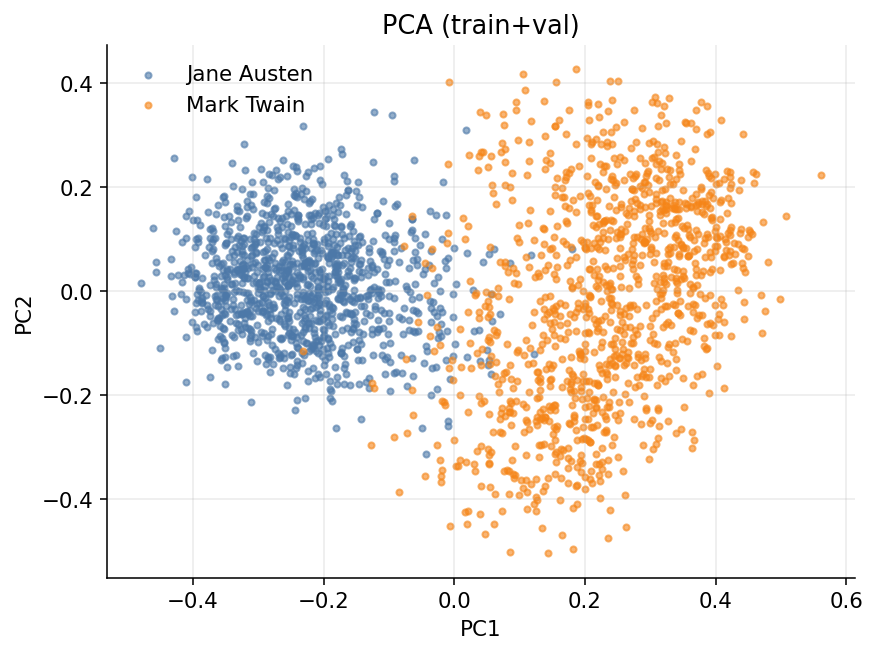

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


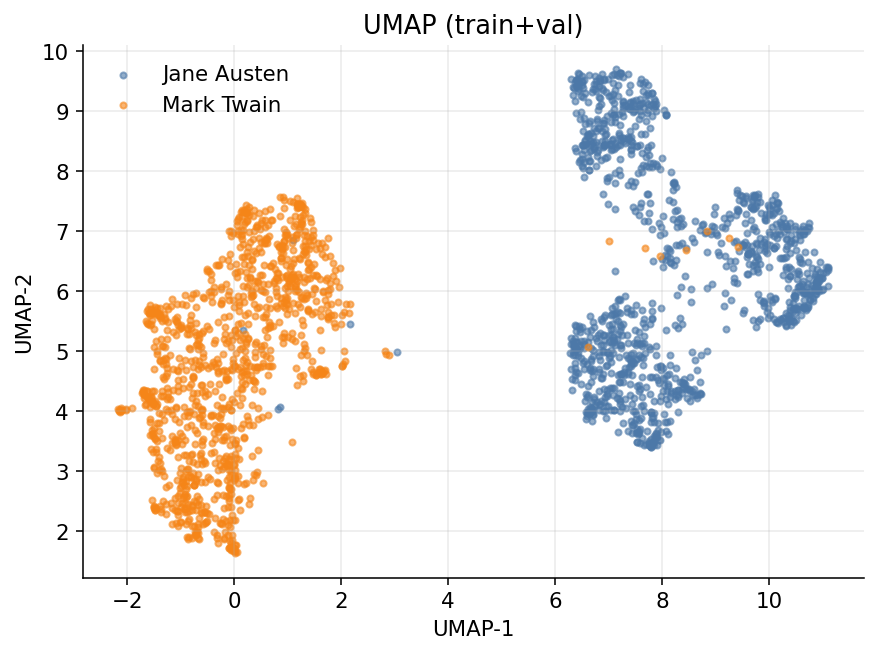

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap

colors = {0:"#4C78A8", 1:"#F58518"}  # Austen, Twain
names  = inv_map

# PCA
pca = PCA(n_components=2, random_state=SEED)
Zp = pca.fit_transform(np.vstack([X_train, X_val]))
labs = np.hstack([y_train, y_val])

fig, ax = plt.subplots(figsize=(6.4,4.8))
for cls in np.unique(labs):
    m = labs==cls
    ax.scatter(Zp[m,0], Zp[m,1], s=10, alpha=0.6, label=names[cls], c=colors[cls])
ax.set_title("PCA (train+val)")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.legend(frameon=False)
plt.tight_layout(); plt.show()

# UMAP
um = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric="cosine", random_state=SEED)
Zu = um.fit_transform(np.vstack([X_train, X_val]))

fig, ax = plt.subplots(figsize=(6.4,4.8))
for cls in np.unique(labs):
    m = labs==cls
    ax.scatter(Zu[m,0], Zu[m,1], s=10, alpha=0.6, label=names[cls], c=colors[cls])
ax.set_title("UMAP (train+val)")
ax.set_xlabel("UMAP-1"); ax.set_ylabel("UMAP-2"); ax.legend(frameon=False)
plt.tight_layout(); plt.show()


In [17]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

Z = np.vstack([X_train, X_val])
labs = np.hstack([y_train, y_val])

sil = silhouette_score(Z, labs, metric="cosine")
ch  = calinski_harabasz_score(Z, labs)
print(f"Silhouette(cosine) = {sil:.3f}")
print(f"Calinski–Harabasz  = {ch:.1f}")


Silhouette(cosine) = 0.152
Calinski–Harabasz  = 204.1


In [18]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, f1_score

clf = LinearSVC(random_state=SEED)
clf.fit(X_train, y_train)

def eval_split(X, y, name):
    pred = clf.predict(X)
    acc = accuracy_score(y, pred)
    f1  = f1_score(y, pred, average="macro")
    print(f"{name:>5s} | acc={acc:.3f}  f1_macro={f1:.3f}")
    print(classification_report(y, pred, target_names=[names[0], names[1]]))

eval_split(X_train, y_train, "train")
eval_split(X_val,   y_val,   "val")
eval_split(X_test,  y_test,  "test")


train | acc=0.998  f1_macro=0.998
              precision    recall  f1-score   support

 Jane Austen       1.00      1.00      1.00       921
  Mark Twain       1.00      1.00      1.00       922

    accuracy                           1.00      1843
   macro avg       1.00      1.00      1.00      1843
weighted avg       1.00      1.00      1.00      1843

  val | acc=0.987  f1_macro=0.987
              precision    recall  f1-score   support

 Jane Austen       0.98      0.99      0.99       198
  Mark Twain       0.99      0.98      0.99       197

    accuracy                           0.99       395
   macro avg       0.99      0.99      0.99       395
weighted avg       0.99      0.99      0.99       395

 test | acc=0.995  f1_macro=0.995
              precision    recall  f1-score   support

 Jane Austen       0.99      1.00      0.99       198
  Mark Twain       1.00      0.99      0.99       198

    accuracy                           0.99       396
   macro avg       0.99   

Test ROC-AUC (binary): 1.000


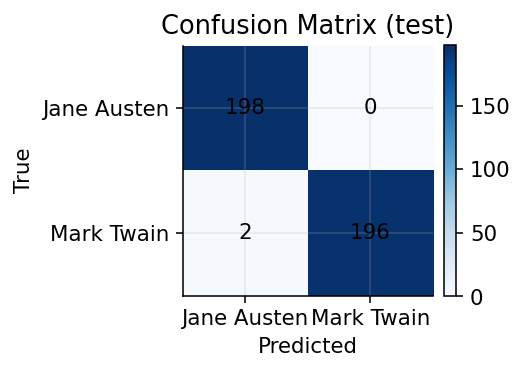

In [19]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, confusion_matrix
import numpy as np, matplotlib.pyplot as plt

# калибруем, чтобы получить predict_proba
cal = CalibratedClassifierCV(clf, cv=3)
cal.fit(X_train, y_train)

proba_test = cal.predict_proba(X_test)          # shape: (n_samples, 2)
y_true = y_test                                  # может оказаться (n_samples, 2)

# приводим y_true к 1D int меткам
if isinstance(y_true, np.ndarray) and y_true.ndim == 2:
    # если это one-hot той же ширины, что и proba
    if y_true.shape[1] == proba_test.shape[1]:
        y_true = y_true.argmax(axis=1)
    else:
        y_true = y_true.ravel()
y_true = y_true.astype(int)

# бинарный ROC-AUC: берём вероятность "положительного" класса (метка 1)
auc_bin = roc_auc_score(y_true, proba_test[:, 1])
print(f"Test ROC-AUC (binary): {auc_bin:.3f}")

# матрица ошибок
pred_test = proba_test.argmax(axis=1)
cm = confusion_matrix(y_true, pred_test)

fig, ax = plt.subplots(figsize=(3.8,3.4))
im = ax.imshow(cm, cmap="Blues")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, int(cm[i,j]), ha="center", va="center")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels([inv_map[0], inv_map[1]])
ax.set_yticklabels([inv_map[0], inv_map[1]])
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_title("Confusion Matrix (test)")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()


# **STEP 4**

In [20]:
import pandas as pd, numpy as np, os, json, math, re, matplotlib.pyplot as plt
from pathlib import Path

# Сплиты
train_df = pd.read_csv(BASE/"data/processed/train.csv")
val_df   = pd.read_csv(BASE/"data/processed/val.csv")
test_df  = pd.read_csv(BASE/"data/processed/test.csv")

# Объединённый датафрейм с пометкой split
train_df["split"] = "train"
val_df["split"]   = "val"
test_df["split"]  = "test"
ALL = pd.concat([train_df, val_df, test_df], ignore_index=True)

# spaCy: оставляем только POS-tagger + sentencizer (без parser/ner/lemmatizer для скорости и стабильных sents)
import spacy, textstat
spacy.util.fix_random_seed(42)
nlp_pos = spacy.load(
    "en_core_web_sm",
    disable=["ner", "parser", "lemmatizer"]  # parser выключен → предложения задаёт sentencizer
)
if "sentencizer" not in nlp_pos.pipe_names:
    nlp_pos.add_pipe("sentencizer")  # быстрые, воспроизводимые границы предложений
nlp_pos.max_length = 10_000_000  # на всякий случай для длинных текстов


In [21]:
from collections import Counter
import numpy as np

# наборы символов пунктуации (для текстового подсчёта)
PUNCT_CHARS = set(list(".,;:!?—-…\"'()[]{}"))

# Используем универсальные POS-метки spaCy (pos_) — они стабильнее к языкам
POS_UPOS = {
    "NOUN": {"NOUN"},
    "VERB": {"VERB", "AUX"},
    "ADJ":  {"ADJ"},
    "ADV":  {"ADV"},
    "PROPN":{"PROPN"},
    "PRON": {"PRON"},  # <-- главное исправление (раньше стояли PRP/PRP$ от tag_)
}

def feat_one_text(doc):
    # токены без пробелов
    toks = [t for t in doc if not t.is_space]
    words_alpha = [t for t in toks if t.is_alpha]
    n_tok = len(toks)
    n_alpha = len(words_alpha)

    # базовые
    sents = list(doc.sents)
    n_sent = max(1, len(sents))
    avg_sent_len = n_tok / n_sent
    avg_word_len = (sum(len(t.text) for t in words_alpha) / max(1, n_alpha))

    # словарное богатство
    uniq = len({t.text.lower() for t in words_alpha})
    ttr = uniq / max(1, n_alpha)

    # пунктуация/знаки
    text = doc.text
    n_excl   = text.count("!")
    n_quest  = text.count("?")
    n_quotes = text.count('"') + text.count("“") + text.count("”") + text.count("'")

    # Доля пунктуации: используем признак spaCy is_punct (надёжнее, чем сравнивать символы)
    punct_ratio = sum(1 for t in toks if t.is_punct or t.text in PUNCT_CHARS) / max(1, n_tok)

    # POS-доли
    pos_counts = Counter(t.pos_ for t in toks)

    def pos_ratio(pos_set):
        return sum(pos_counts.get(p, 0) for p in pos_set) / max(1, n_tok)

    r_noun  = pos_ratio(POS_UPOS["NOUN"])
    r_verb  = pos_ratio(POS_UPOS["VERB"])
    r_adj   = pos_ratio(POS_UPOS["ADJ"])
    r_adv   = pos_ratio(POS_UPOS["ADV"])
    r_propn = pos_ratio(POS_UPOS["PROPN"])
    r_pron  = pos_ratio(POS_UPOS["PRON"])

    # читаемость (страхуемся от краевых случаев)
    try:
        fk = float(textstat.flesch_kincaid_grade(text))
    except Exception:
        fk = np.nan

    return {
        "n_tokens": n_tok,
        "n_sents": n_sent,
        "avg_sent_len": avg_sent_len,
        "avg_word_len": avg_word_len,
        "ttr": ttr,
        "punct_ratio": punct_ratio,
        "excl_per_1k":  n_excl  * 1000 / max(1, n_tok),
        "quest_per_1k": n_quest * 1000 / max(1, n_tok),
        "quotes_per_1k": n_quotes * 1000 / max(1, n_tok),
        "pos_ratio_noun":  r_noun,
        "pos_ratio_verb":  r_verb,
        "pos_ratio_adj":   r_adj,
        "pos_ratio_adv":   r_adv,
        "pos_ratio_propn": r_propn,
        "pos_ratio_pron":  r_pron,
        "fk_grade": fk,
    }

def compute_stylometry(df, out_csv, batch_size=64, overwrite=False):
    out_csv = Path(out_csv)
    if out_csv.exists() and not overwrite:
        return pd.read_csv(out_csv)

    recs = []
    # n_process=1 делает результаты детерминированными и безопасен в Colab
    for doc, row in zip(nlp_pos.pipe(df["text"].tolist(), batch_size=batch_size, n_process=1),
                        df.itertuples()):
        f = feat_one_text(doc)
        f.update({"author": row.author, "title": row.title, "split": row.split})
        recs.append(f)

    res = pd.DataFrame(recs)
    res.to_csv(out_csv, index=False)
    return res


In [22]:
STY_CSV = BASE/"results/tables/stylometry_passages.csv"
sty = compute_stylometry(ALL, STY_CSV)

agg = (sty.groupby(["author"])
          .agg({c:["mean","std"] for c in sty.columns if c not in ["author","title","split"]})
          .round(3))
AGG_CSV = BASE/"results/tables/stylometry_author_agg.csv"
agg.to_csv(AGG_CSV)
print("Saved stylometry:", STY_CSV)
print("Saved aggregates:", AGG_CSV)
agg


Saved stylometry: /content/ctrl_style/results/tables/stylometry_passages.csv
Saved aggregates: /content/ctrl_style/results/tables/stylometry_author_agg.csv


n_tokens         n_sents        avg_sent_len         avg_word_len  \
                mean     std    mean    std         mean     std         mean   
author                                                                          
Jane Austen  277.864  20.830  10.661  4.447       31.299  16.365        4.346   
Mark Twain   280.642  19.067  12.612  5.340       26.863  14.325        3.963   

                      ttr         ... pos_ratio_adj        pos_ratio_adv  \
               std   mean    std  ...          mean    std          mean   
author                            ...                                      
Jane Austen  0.262  0.599  0.033  ...         0.057  0.017         0.059   
Mark Twain   0.323  0.576  0.046  ...         0.048  0.019         0.053   

                   pos_ratio_propn        pos_ratio_pron        fk_grade  \
               std            mean    std           mean    std     mean   
author                                                                     
Jane Austen  0.017           0.046  0.026          0.120  0.028    9.940   
Mark Twain   0.018           0.029  0.039          0.116  0.031    8.402   

                    
               std  
author              
Jane Austen  4.025  
Mark Twain   5.064  

[2 rows x 32 columns]

/tmp/ipython-input-3372855581.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_a.dropna(), data_b.dropna()], labels=sty.author.unique(), showfliers=False)
/tmp/ipython-input-3372855581.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_a.dropna(), data_b.dropna()], labels=sty.author.unique(), showfliers=False)
/tmp/ipython-input-3372855581.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_a.dropna(), data_b.dropna()], labels=sty.author.unique(), showfliers=False)
/tmp/ipython-input-3372855581.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot(

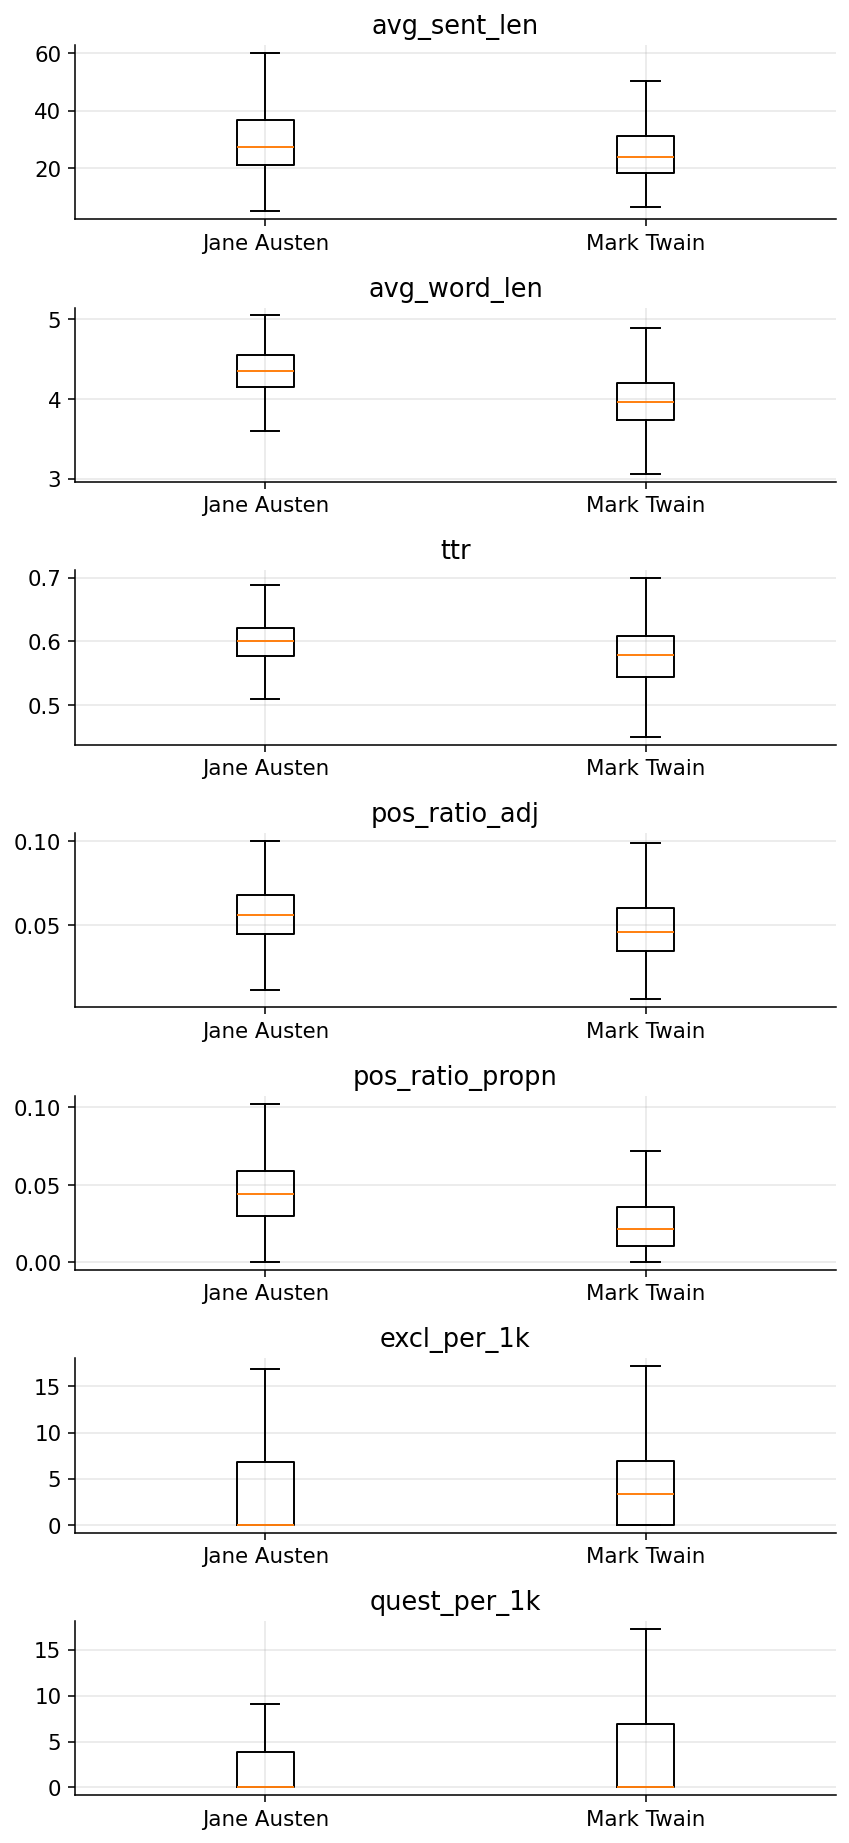

In [23]:
import matplotlib.pyplot as plt
FEATS = ["avg_sent_len","avg_word_len","ttr","pos_ratio_adj","pos_ratio_propn","excl_per_1k","quest_per_1k"]

fig, axes = plt.subplots(len(FEATS), 1, figsize=(6.2, 1.9*len(FEATS)))
if len(FEATS)==1: axes=[axes]
for ax, feat in zip(axes, FEATS):
    data_a = sty.loc[sty.author==sty.author.unique()[0], feat]
    data_b = sty.loc[sty.author==sty.author.unique()[1], feat]
    ax.boxplot([data_a.dropna(), data_b.dropna()], labels=sty.author.unique(), showfliers=False)
    ax.set_title(feat)
    ax.grid(alpha=0.3)
plt.tight_layout(); plt.show()


In [24]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, f1_score

USE_FEATS = [c for c in sty.columns if c not in ["author","title","split","n_tokens","n_sents"]]
def split_Xy(frame):
    X = frame[USE_FEATS].to_numpy()
    y = (frame["author"]==sorted(sty.author.unique())[1]).astype(int).to_numpy()  # бинарные метки
    return X, y

Xtr, ytr = split_Xy(sty[sty.split=="train"])
Xva, yva = split_Xy(sty[sty.split=="val"])
Xte, yte = split_Xy(sty[sty.split=="test"])

clf_sty = LinearSVC(random_state=SEED)
clf_sty.fit(Xtr, ytr)

def eval_split(X, y, name):
    pred = clf_sty.predict(X)
    acc = accuracy_score(y, pred)
    f1  = f1_score(y, pred)
    print(f"{name:>5s} | acc={acc:.3f}  f1={f1:.3f}")
    print(classification_report(y, pred, target_names=sorted(sty.author.unique())))

eval_split(Xtr, ytr, "train")
eval_split(Xva, yva, "val")
eval_split(Xte, yte, "test")


train | acc=0.880  f1=0.879
              precision    recall  f1-score   support

 Jane Austen       0.88      0.88      0.88       921
  Mark Twain       0.88      0.88      0.88       922

    accuracy                           0.88      1843
   macro avg       0.88      0.88      0.88      1843
weighted avg       0.88      0.88      0.88      1843

  val | acc=0.853  f1=0.853
              precision    recall  f1-score   support

 Jane Austen       0.85      0.85      0.85       198
  Mark Twain       0.85      0.85      0.85       197

    accuracy                           0.85       395
   macro avg       0.85      0.85      0.85       395
weighted avg       0.85      0.85      0.85       395

 test | acc=0.861  f1=0.858
              precision    recall  f1-score   support

 Jane Austen       0.85      0.88      0.86       198
  Mark Twain       0.88      0.84      0.86       198

    accuracy                           0.86       396
   macro avg       0.86      0.86      0.86 

In [25]:
coef = pd.Series(clf_sty.coef_.ravel(), index=USE_FEATS).sort_values()
TOP = 12
top_neg = coef.head(TOP)   # маркеры автора 0
top_pos = coef.tail(TOP)   # маркеры автора 1

imp = pd.concat([top_neg, top_pos]).to_frame("weight")
IMP_CSV = BASE/"results/tables/stylometry_feature_importance.csv"
imp.to_csv(IMP_CSV)
print("Saved:", IMP_CSV)
imp


Saved: /content/ctrl_style/results/tables/stylometry_feature_importance.csv


,weight
pos_ratio_pron,-5.504064
pos_ratio_adj,-2.690980
avg_word_len,-2.449588
pos_ratio_verb,-2.238241
pos_ratio_adv,-2.080525
pos_ratio_propn,-0.888759
avg_sent_len,-0.026911
excl_per_1k,-0.001445
quotes_per_1k,-0.000635
quest_per_1k,0.002116


# **STEP 5**

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Только train для fit; val/test — transform
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=5,
    max_df=0.6,
    stop_words="english",
    strip_accents="unicode",
    sublinear_tf=True,
    lowercase=True
)

Xtr_tfidf = vec.fit_transform(train_df["text"])
Xva_tfidf = vec.transform(val_df["text"])
Xte_tfidf = vec.transform(test_df["text"])

author2id = {a:i for i,a in enumerate(sorted(train_df["author"].unique()))}
ytr = train_df["author"].map(author2id).to_numpy()
yva = val_df["author"].map(author2id).to_numpy()
yte = test_df["author"].map(author2id).to_numpy()

Xtr_tfidf.shape, len(vec.get_feature_names_out())


((1843, 5868), 5868)

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

logit = LogisticRegression(
    penalty="l2", C=4.0, solver="liblinear", random_state=SEED, max_iter=200
)
logit.fit(Xtr_tfidf, ytr)

def eval_lr(X, y, name):
    pred = logit.predict(X)
    print(f"{name:>5s} | acc={accuracy_score(y,pred):.3f}  f1_macro={f1_score(y,pred,average='macro'):.3f}")
    print(classification_report(y, pred, target_names=sorted(author2id, key=lambda k: author2id[k])))

eval_lr(Xtr_tfidf, ytr, "train")
eval_lr(Xva_tfidf, yva, "val")
eval_lr(Xte_tfidf, yte, "test")


train | acc=1.000  f1_macro=1.000
              precision    recall  f1-score   support

 Jane Austen       1.00      1.00      1.00       921
  Mark Twain       1.00      1.00      1.00       922

    accuracy                           1.00      1843
   macro avg       1.00      1.00      1.00      1843
weighted avg       1.00      1.00      1.00      1843

  val | acc=1.000  f1_macro=1.000
              precision    recall  f1-score   support

 Jane Austen       1.00      1.00      1.00       198
  Mark Twain       1.00      1.00      1.00       197

    accuracy                           1.00       395
   macro avg       1.00      1.00      1.00       395
weighted avg       1.00      1.00      1.00       395

 test | acc=1.000  f1_macro=1.000
              precision    recall  f1-score   support

 Jane Austen       1.00      1.00      1.00       198
  Mark Twain       1.00      1.00      1.00       198

    accuracy                           1.00       396
   macro avg       1.00   

In [28]:
import numpy as np, pandas as pd

feat = np.array(vec.get_feature_names_out())
coef = logit.coef_.ravel()

# положительные — в сторону автора с id==1; отрицательные — автора id==0
TOP = 25
top_pos_idx = np.argsort(coef)[-TOP:]
top_neg_idx = np.argsort(coef)[:TOP]

top_table = pd.DataFrame({
    "marker_for": [sorted(author2id, key=lambda k: author2id[k])[1]]*TOP + \
                  [sorted(author2id, key=lambda k: author2id[k])[0]]*TOP,
    "ngram": list(feat[top_pos_idx][::-1]) + list(feat[top_neg_idx]),
    "weight": list(coef[top_pos_idx][::-1]) + list(coef[top_neg_idx])
})

MARKERS_CSV = BASE/"results/tables/tfidf_top_markers.csv"
top_table.to_csv(MARKERS_CSV, index=False)
print("Saved:", MARKERS_CSV)
top_table.head(10)


Saved: /content/ctrl_style/results/tables/tfidf_top_markers.csv


,marker_for,ngram,weight
0,Mark Twain,tom,4.008876
1,Mark Twain,king,3.628930
2,Mark Twain,got,3.205636
3,Mark Twain,didn,2.945426
4,Mark Twain,don,2.853729
5,Mark Twain,ll,2.441700
6,Mark Twain,couldn,2.368815
7,Mark Twain,says,2.312030
8,Mark Twain,right,2.116150
9,Mark Twain,ye,2.086370


In [29]:
def print_markers(tbl, author_name, k=15):
    sub = tbl[tbl["marker_for"]==author_name].head(k)
    print(f"\nTop markers for {author_name}:")
    for i,(g,w) in enumerate(zip(sub["ngram"], sub["weight"]), 1):
        print(f"{i:2d}. {g:30s}  {w:+.3f}")

authors_sorted = sorted(author2id, key=lambda k: author2id[k])
print_markers(top_table, authors_sorted[0], k=15)
print_markers(top_table, authors_sorted[1], k=15)



Top markers for Jane Austen:
 1. mr                              -5.411
 2. mrs                             -4.296
 3. miss                            -3.893
 4. emma                            -3.651
 5. elinor                          -3.494
 6. elizabeth                       -3.493
 7. marianne                        -3.316
 8. sister                          -2.640
 9. harriet                         -2.544
10. dear                            -2.294
11. darcy                           -2.258
12. jane                            -2.173
13. father                          -2.071
14. knightley                       -2.040
15. think                           -2.031

Top markers for Mark Twain:
 1. tom                             +4.009
 2. king                            +3.629
 3. got                             +3.206
 4. didn                            +2.945
 5. don                             +2.854
 6. ll                              +2.442
 7. couldn                          +2

# **STEP 6**

In [30]:
import pandas as pd, numpy as np, joblib, json, os, torch
from pathlib import Path
from sentence_transformers import SentenceTransformer

# Пути и данные
MODELS_DIR = BASE/"results/models"
GEN_DIR    = BASE/"results/transfer"
GEN_DIR.mkdir(parents=True, exist_ok=True)

train_df = pd.read_csv(BASE/"data/processed/train.csv")
test_df  = pd.read_csv(BASE/"data/processed/test.csv")

# Метки авторов (в том же порядке, как в блоке C)
with open(MODELS_DIR/"meta.json") as f:
    meta = json.load(f)
label_map = {a:i for i,a in enumerate(sorted(train_df["author"].unique()))}
inv_map   = {v:k for k,v in label_map.items()}
inv_map

# Подгружаем/учим быстрый стиль-классификатор на эмбеддингах (для style-score)
X_train = np.load(MODELS_DIR/"X_train.npy")
y_train = np.load(MODELS_DIR/"y_train.npy")

from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

clf = LinearSVC(random_state=42).fit(X_train, y_train)
cal = CalibratedClassifierCV(clf, cv=3).fit(X_train, y_train)

# Эмбеддер для оценки смысла (SBERT cosine)
device = "cuda" if torch.cuda.is_available() else "cpu"
sbert = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)
sbert.max_seq_length = 256

print("Ready. Authors:", inv_map)


Ready. Authors: {0: 'Jane Austen', 1: 'Mark Twain'}


In [31]:
import textwrap

STYLE_GUIDE = {
    "Jane Austen": textwrap.dedent("""
        Write like Jane Austen (early 19th-century British prose).
        Tone: refined, lightly ironic, third-person limited.
        Syntax: longer sentences with balanced clauses; occasional semicolons.
        Diction: formal register; genteel vocabulary; no slang or dialect.
    """).strip(),
    "Mark Twain": textwrap.dedent("""
        Write like Mark Twain (19th-century American prose).
        Tone: colloquial, conversational, dry humor.
        Syntax: mostly short to medium sentences; rhythmic.
        Diction: plain words; mild regional flavor without heavy eye-dialect.
    """).strip()
}

def make_prompt(target_author, text, min_words=150, max_words=230):
    guide = STYLE_GUIDE[target_author]
    instr = f"""
You are a careful rewriter.

TASK:
Rewrite the PASSAGE **fully in new wording** in the style of {target_author}.
Keep all facts, names, places, events. Do not add or remove events.

HARD CONSTRAINTS (must follow):
- English only; no meta-comments.
- Do NOT quote or copy phrases longer than 8 words from the original.
- Avoid lists, bullet points, stage directions, or dialogue-as-script.
- Output length: {min_words}–{max_words} words.

STYLE GUIDELINES:
{guide}

PASSAGE:
\"\"\"{text.strip()}\"\"\"

OUTPUT (continuous prose, one or more paragraphs):
""".strip()
    return instr


In [32]:
import re, torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

GEN_MODEL = "google/flan-t5-large"  # если OOM: "google/flan-t5-base"
tok = AutoTokenizer.from_pretrained(GEN_MODEL)
gen_model = AutoModelForSeq2SeqLM.from_pretrained(GEN_MODEL).to(device)

def _sanitize(text: str) -> str:
    text = re.sub(r'^\s*["“”]+', '', text.strip())
    text = text.replace('"""', '').strip()
    # схлопываем повторяющиеся фразы/предложения
    text = re.sub(r'(\b[^.!?]{3,40}[.!?])(\s*\1){2,}', r'\1', text, flags=re.IGNORECASE)
    return text

def generate_style(target_author, texts, batch_size=2, max_new_tokens=320,
                   temperature=0.9, top_p=0.92, no_repeat_ngram_size=4,
                   repetition_penalty=1.18, length_penalty=1.02, retries=2):
    outs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        cur_prompts = [make_prompt(target_author, t) for t in batch]

        for attempt in range(retries + 1):
            enc = tok(cur_prompts, return_tensors="pt", padding=True, truncation=True).to(device)
            with torch.no_grad():
                gen = gen_model.generate(
                    **enc,
                    do_sample=True,
                    temperature=temperature, top_p=top_p,
                    no_repeat_ngram_size=no_repeat_ngram_size,
                    repetition_penalty=repetition_penalty,
                    length_penalty=length_penalty,
                    num_beams=1,
                    max_new_tokens=max_new_tokens,
                    early_stopping=True,
                )
            cand = [_sanitize(x) for x in tok.batch_decode(gen, skip_special_tokens=True)]

            # перегенерация, если копипаста/слишком коротко
            need_retry = []
            for j, (src, hyp) in enumerate(zip(batch, cand)):
                src_low = re.sub(r'\s+', ' ', src.lower()).strip()
                hyp_low = re.sub(r'\s+', ' ', hyp.lower()).strip()
                overlap = sum(1 for m in re.finditer(r'\b\w+(?:\s+\w+){5,}\b', hyp_low) if m.group(0) in src_low)
                if overlap > 0 or len(hyp_low.split()) < 120:
                    need_retry.append(j)

            if not need_retry or attempt == retries:
                outs.extend(cand)
                break

            # увеличиваем разнообразие только для проблемных
            for j in need_retry:
                cur_prompts[j] = make_prompt(target_author, batch[j])
            temperature = min(1.2, temperature + 0.1)
            top_p = min(0.98, top_p + 0.02)
    return outs


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [33]:
import numpy as np, pandas as pd
from pathlib import Path

# Поднабор для эксперимента
np.random.seed(42)
N_PER_AUTHOR = 25

test_austen = test_df[test_df.author=="Jane Austen"].sample(N_PER_AUTHOR, random_state=42).reset_index(drop=True)
test_twain  = test_df[test_df.author=="Mark Twain"].sample(N_PER_AUTHOR,  random_state=42).reset_index(drop=True)

A2T_CSV = GEN_DIR/"austen_to_twain.csv"
T2A_CSV = GEN_DIR/"twain_to_austen.csv"

# опционально очистить старые результаты, чтобы точно пересоздать
for p in [A2T_CSV, T2A_CSV]:
    try: Path(p).unlink()
    except FileNotFoundError: pass

def ensure_gen(src_df, target_author, out_csv):
    gens = generate_style(target_author, src_df["text"].tolist())
    out = src_df.copy()
    out["target_author"] = target_author
    out["rewritten"] = gens
    out.to_csv(out_csv, index=False)
    print("[saved]", out_csv)
    return out

a2t = ensure_gen(test_austen, "Mark Twain", A2T_CSV)   # Austen → Twain
t2a = ensure_gen(test_twain,  "Jane Austen", T2A_CSV)  # Twain  → Austen

len(a2t), len(t2a)


The following generation flags are not valid and may be ignored: ['early_stopping', 'length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[saved] /content/ctrl_style/results/transfer/austen_to_twain.csv
[saved] /content/ctrl_style/results/transfer/twain_to_austen.csv


(25, 25)

In [34]:
import textstat
import numpy as np
import pandas as pd

def sbert_embed(texts):
    return sbert.encode(texts, batch_size=64, convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=False)

def evaluate_transfer(df):
    # style score
    X_src = sbert_embed(df["text"].tolist())
    X_new = sbert_embed(df["rewritten"].tolist())
    proba_new = cal.predict_proba(X_new)
    target_id = label_map[df["target_author"].iloc[0]]
    style_score = proba_new[:, target_id]

    # content preservation
    cos = (X_src * X_new).sum(axis=1)

    # readability ΔFK
    def safe_fk(t):
        try: return float(textstat.flesch_kincaid_grade(t))
        except: return np.nan
    fk_src = [safe_fk(t) for t in df["text"]]
    fk_new = [safe_fk(t) for t in df["rewritten"]]
    fk_delta = np.array(fk_new) - np.array(fk_src)

    out = df.copy()
    out["style_score"] = style_score
    out["sbert_cosine"] = cos
    out["fk_src"] = fk_src
    out["fk_new"] = fk_new
    out["fk_delta"] = fk_delta
    return out

eval_a2t = evaluate_transfer(a2t)
eval_t2a = evaluate_transfer(t2a)

EVAL_A2T = GEN_DIR/"eval_a2t.csv"; eval_a2t.to_csv(EVAL_A2T, index=False)
EVAL_T2A = GEN_DIR/"eval_t2a.csv"; eval_t2a.to_csv(EVAL_T2A, index=False)
eval_a2t[["style_score","sbert_cosine","fk_delta"]].describe().round(3), \
eval_t2a[["style_score","sbert_cosine","fk_delta"]].describe().round(3)


(       style_score  sbert_cosine  fk_delta
 count       25.000        25.000    25.000
 mean         0.244         0.548    -2.216
 std          0.350         0.247     3.706
 min          0.000         0.127   -10.446
 25%          0.001         0.356    -4.644
 50%          0.019         0.577    -1.466
 75%          0.478         0.764     0.482
 max          0.958         0.916     4.244,
        style_score  sbert_cosine  fk_delta
 count       25.000        25.000    25.000
 mean         0.092         0.458    -2.820
 std          0.210         0.251     6.213
 min          0.000         0.081   -19.042
 25%          0.000         0.298    -5.330
 50%          0.002         0.411    -0.613
 75%          0.017         0.630     0.785
 max          0.811         0.933     5.257)

In [35]:
def summary_row(name, df):
    return {
        "direction": name,
        "n": len(df),
        "style_score_mean": float(df["style_score"].mean()),
        "style_score_med":  float(df["style_score"].median()),
        "content_cos_mean": float(df["sbert_cosine"].mean()),
        "content_cos_med":  float(df["sbert_cosine"].median()),
        "fk_delta_mean":    float(df["fk_delta"].mean())
    }

summary = pd.DataFrame([
    summary_row("Austen→Twain", eval_a2t),
    summary_row("Twain→Austen", eval_t2a),
]).round(3)
summary.to_csv(GEN_DIR/"summary.csv", index=False)
summary

import textwrap
def show_examples(df, k=2):
    for _, row in df.sample(k, random_state=42).iterrows():
        print("\n—"*40)
        print(f"Source: {row['author']}  →  Target: {row['target_author']}")
        print(f"style_score={row['style_score']:.2f}  cosine={row['sbert_cosine']:.2f}  ΔFK={row['fk_delta']:+.2f}")
        print("\nORIGINAL:\n", textwrap.shorten(row['text'], width=700, placeholder="…"))
        print("\nREWRITTEN:\n", textwrap.shorten(row['rewritten'], width=700, placeholder="…"))

print("\n=== Austen → Twain ===")
show_examples(eval_a2t, k=2)
print("\n=== Twain → Austen ===")
show_examples(eval_t2a, k=2)



=== Austen → Twain ===

—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
Source: Jane Austen  →  Target: Mark Twain
style_score=0.00  cosine=0.63  ΔFK=+1.06

ORIGINAL:
 We have certainly done our best; and most fortunately having it in our power to introduce you to very superior society, and from our connection with Rosings, the frequent means of varying the humble home scene, I think we may flatter ourselves that your Hunsford visit cannot have been entirely irksome. Our situation with regard to Lady Catherine’s family is, indeed, the sort of extraordinary advantage and blessing which few can boast. You see on what a footing we are. You see how continually we are engaged there. In truth, I must acknowledge, that, with all the disadvantages of this humble parsonage, I should not think anyone abiding in it an object of compassion, while they are sharers of…

REWRITTEN:
 Mrs. Collins, to whom Elizabeth had been witness for a long time, was an innocent, liv

Saved figure: /content/ctrl_style/results/figures/01_passage_length_hist.png


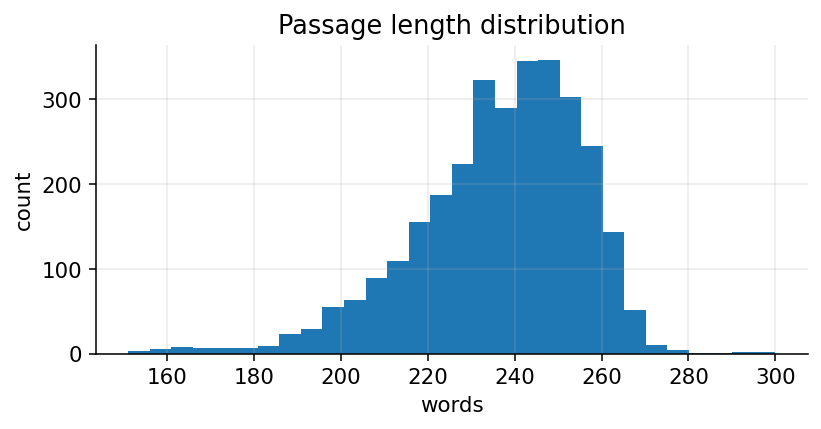

Saved figure: /content/ctrl_style/results/figures/02_pca_train_val.png


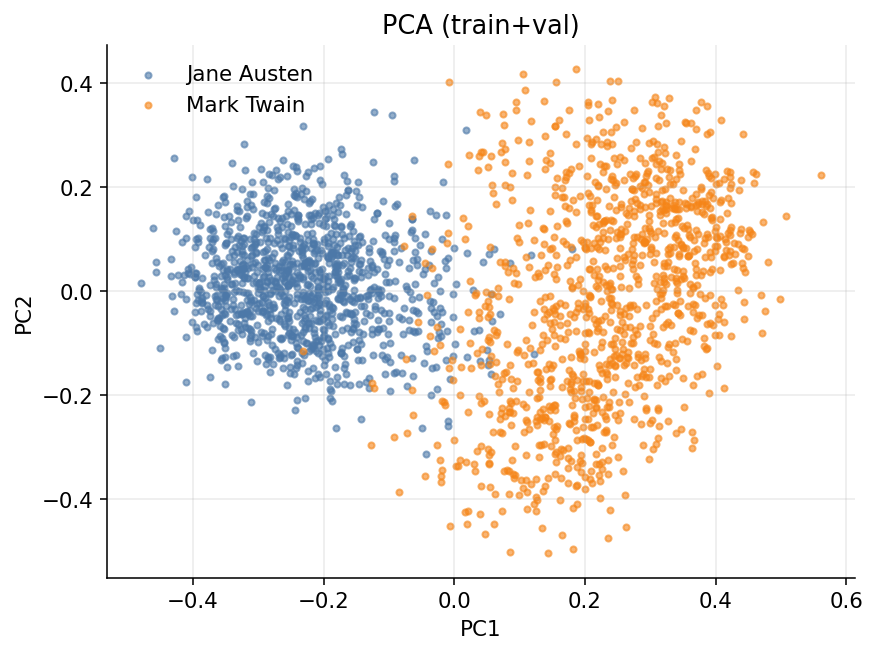

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved figure: /content/ctrl_style/results/figures/03_umap_train_val.png


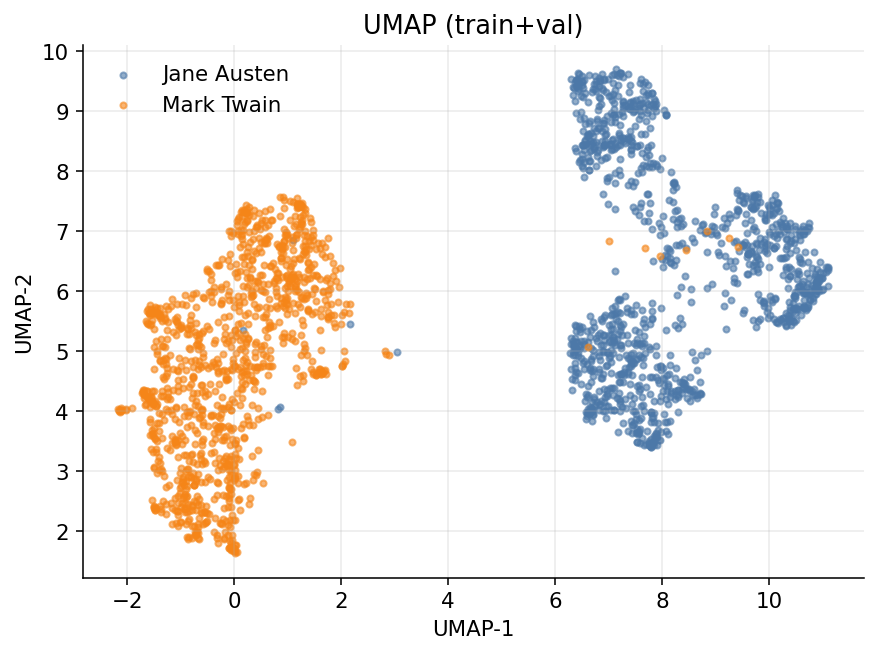

Test accuracy=0.995  f1_macro=0.995
Saved figure: /content/ctrl_style/results/figures/04_confusion_matrix_test.png


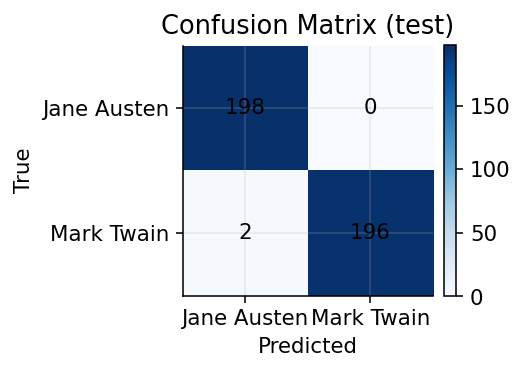

/tmp/ipython-input-252019243.py:149: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_a, data_b],
/tmp/ipython-input-252019243.py:149: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_a, data_b],
/tmp/ipython-input-252019243.py:149: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_a, data_b],
/tmp/ipython-input-252019243.py:149: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_a, data_b],
/tmp/ipython-input-252019243.py:149: MatplotlibDepre

Saved figure: /content/ctrl_style/results/figures/05_stylometry_boxplots.png


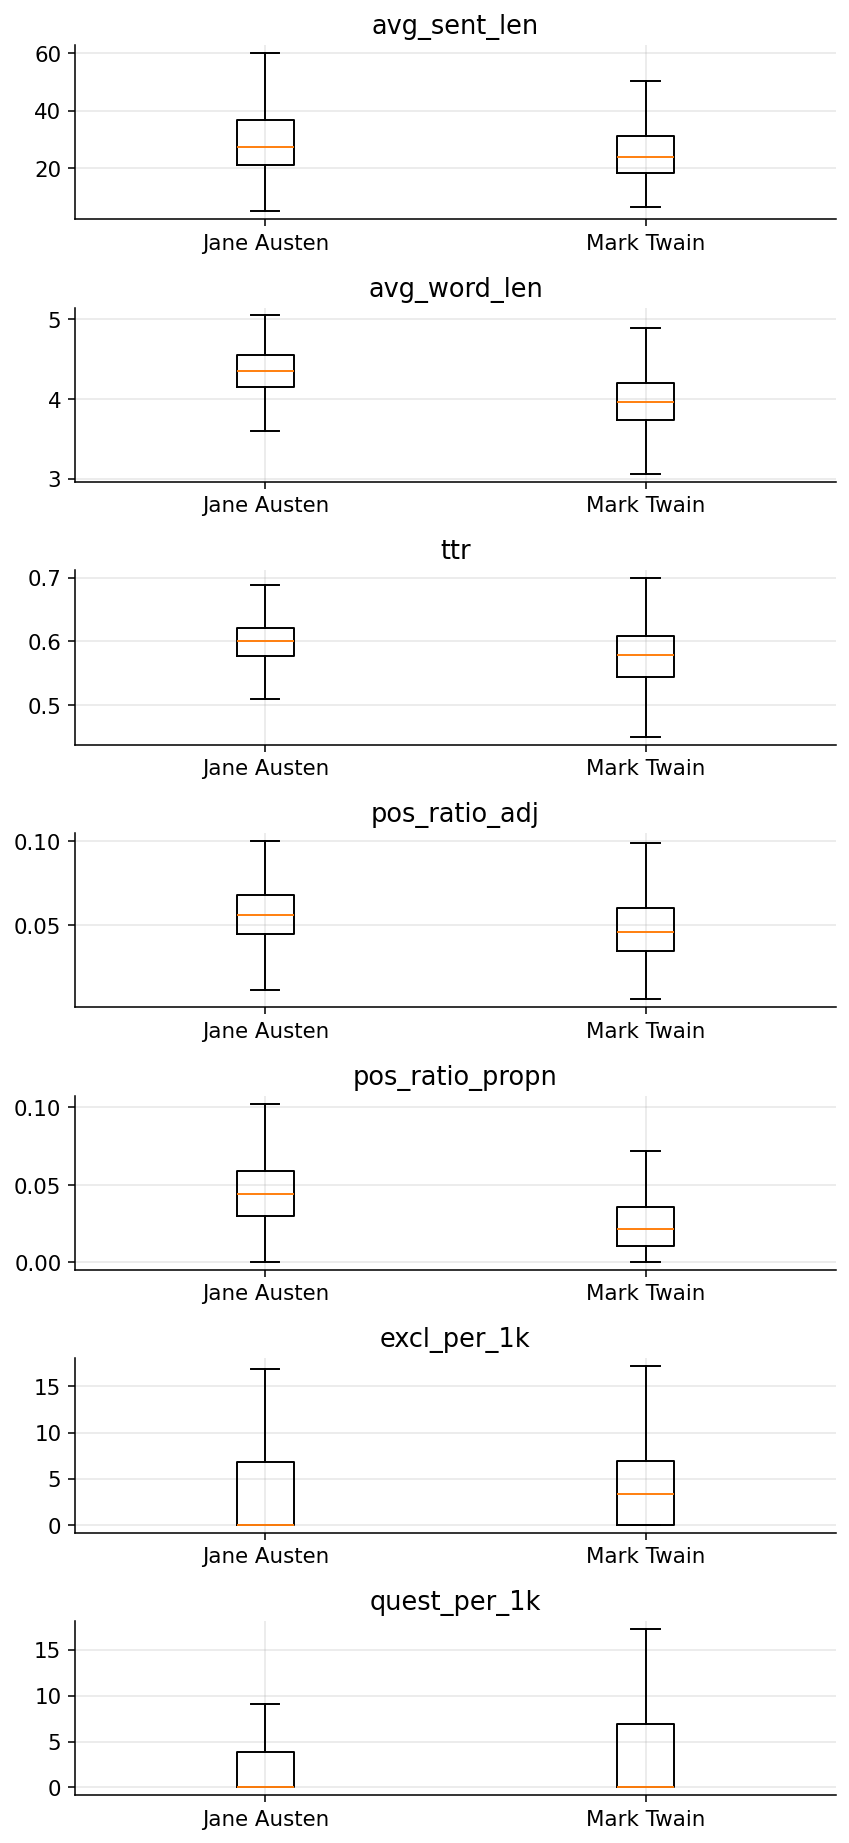

All figures regenerated and saved in: /content/ctrl_style/results/figures


In [36]:
# === FINAL STEP: regenerate & save all key figures ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.svm import LinearSVC
import umap

SEED = 42
PROJECT = "ctrl_style"
BASE = Path("/content") / PROJECT

MODELS_DIR = BASE / "results/models"
FIG_DIR    = BASE / "results/figures"
TABLE_DIR  = BASE / "results/tables"
FIG_DIR.mkdir(parents=True, exist_ok=True)

def savefig(name):
    path = FIG_DIR / name
    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print("Saved figure:", path)

# ---------- 1) Passage length distribution ----------
PASSAGES_CSV = BASE / "data/processed/passages.csv"
dfp = pd.read_csv(PASSAGES_CSV)

fig, ax = plt.subplots(figsize=(6, 3.2))
dfp["n_words"].plot.hist(bins=30, ax=ax)
ax.set_title("Passage length distribution")
ax.set_xlabel("words")
ax.set_ylabel("count")
savefig("01_passage_length_hist.png")
plt.show()

# ---------- 2) Load splits, labels, embeddings ----------
train_df = pd.read_csv(BASE / "data/processed/train.csv")
val_df   = pd.read_csv(BASE / "data/processed/val.csv")
test_df  = pd.read_csv(BASE / "data/processed/test.csv")

label_map = {a: i for i, a in enumerate(sorted(train_df["author"].unique()))}
inv_map   = {v: k for k, v in label_map.items()}

y_train = train_df["author"].map(label_map).to_numpy()
y_val   = val_df["author"].map(label_map).to_numpy()
y_test  = test_df["author"].map(label_map).to_numpy()

X_train = np.load(MODELS_DIR / "X_train.npy")
X_val   = np.load(MODELS_DIR / "X_val.npy")
X_test  = np.load(MODELS_DIR / "X_test.npy")

colors = {0: "#4C78A8", 1: "#F58518"}  # Austen, Twain

# ---------- 3) PCA (train+val) ----------
pca = PCA(n_components=2, random_state=SEED)
Zp = pca.fit_transform(np.vstack([X_train, X_val]))
labs = np.hstack([y_train, y_val])

fig, ax = plt.subplots(figsize=(6.4, 4.8))
for cls in np.unique(labs):
    m = labs == cls
    ax.scatter(Zp[m, 0], Zp[m, 1],
               s=10, alpha=0.6,
               label=inv_map[cls],
               c=colors[cls])
ax.set_title("PCA (train+val)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend(frameon=False)
savefig("02_pca_train_val.png")
plt.show()

# ---------- 4) UMAP (train+val) ----------
um = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=SEED
)
Zu = um.fit_transform(np.vstack([X_train, X_val]))

fig, ax = plt.subplots(figsize=(6.4, 4.8))
for cls in np.unique(labs):
    m = labs == cls
    ax.scatter(Zu[m, 0], Zu[m, 1],
               s=10, alpha=0.6,
               label=inv_map[cls],
               c=colors[cls])
ax.set_title("UMAP (train+val)")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.legend(frameon=False)
savefig("03_umap_train_val.png")
plt.show()

# ---------- 5) LinearSVC + confusion matrix ----------
clf = LinearSVC(random_state=SEED)
clf.fit(X_train, y_train)

pred_test = clf.predict(X_test)
acc = accuracy_score(y_test, pred_test)
f1  = f1_score(y_test, pred_test, average="macro")
print(f"Test accuracy={acc:.3f}  f1_macro={f1:.3f}")

cm = confusion_matrix(y_test, pred_test)

fig, ax = plt.subplots(figsize=(3.8, 3.4))
im = ax.imshow(cm, cmap="Blues")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, int(cm[i, j]),
                ha="center", va="center")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels([inv_map[0], inv_map[1]])
ax.set_yticklabels([inv_map[0], inv_map[1]])
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix (test)")
plt.colorbar(im, fraction=0.046, pad=0.04)
savefig("04_confusion_matrix_test.png")
plt.show()

# ---------- 6) Stylometry boxplots ----------
sty = pd.read_csv(TABLE_DIR / "stylometry_passages.csv")

FEATS = [
    "avg_sent_len",
    "avg_word_len",
    "ttr",
    "pos_ratio_adj",
    "pos_ratio_propn",
    "excl_per_1k",
    "quest_per_1k",
]

authors = list(sty["author"].unique())
fig, axes = plt.subplots(len(FEATS), 1,
                         figsize=(6.2, 1.9 * len(FEATS)))
if len(FEATS) == 1:
    axes = [axes]

for ax, feat in zip(axes, FEATS):
    data_a = sty.loc[sty.author == authors[0], feat].dropna()
    data_b = sty.loc[sty.author == authors[1], feat].dropna()
    ax.boxplot([data_a, data_b],
               labels=authors,
               showfliers=False)
    ax.set_title(feat)
    ax.grid(alpha=0.3)

savefig("05_stylometry_boxplots.png")
plt.show()

print("All figures regenerated and saved in:", FIG_DIR)


In [37]:
import shutil

shutil.make_archive("/content/ctrl_style", "zip", "/content/ctrl_style")

print("Готово! Файл создан: /content/ctrl_style.zip")


Готово! Файл создан: /content/ctrl_style.zip
